# Exp10

## wanderer2
- **wanderer2 is similar to that of wanderer1. The diffrence is**
    - the agent actions are
        - to move (up, down, left, right, or neutral; same as wanderer1) and 
        - to say **"A", "B", or "C"**
            - "A": using "energy" to get a wider visible range (same as wanderer2)
            - "B": using "attention" to get the other agents' poisitions as features
                - in other words, the agent don't know the other agents' poisition without saying "B".
                - **↑ this difference is essentail.**
            - "C": do nothing
    - "energy" is the same as that of wanderer1
    - "attention" is a new attribute.
        - when the agent says "B", it uses "attention" and get other agents' position as features.
        - "attention" decreases by 1 for every utterence.
        - negative reward of "penalty_weight2 x attention" is added to the agent every step.
            - this mechanism is the smae as that of "energy"
        - the negative reward impact can be changed by "penalty_weight2".

#### The essential difference is the following:
- in wanderer1, the agent can get other agents' position without effort.
- in wanderer2, the agent needs to take an action of "B" to get it.
    - i.e., they **select** getting info of the other positions instead of widing a view range.
    - in ohter words, they **need to make a decision** of which information to get.

Let us see how this change affects the results.

## wanderer2_2agents
- 2 agents and 1 goal landmark

### In the following, I made experiments with different parameter set.
Parameters of "PENALTY_WEIGHT" and "PENALTY_WEIGHT2" control heaviness  
of the penalty for the consumption of the energy and the attention respectively.  
In most cases, only "PENALTY_WEIGHT2" is changed.  
The results are described in the following cells.

## The parameter set
### wander2_2agents-1 
 (penalty_weight=0.0, penalty_weight2=0.0)
 
### wander2_2agents-2 
 (penalty_weight=0.01, penalty_weight2=0.0)
 
### wander2_2agents-3 
 (penalty_weight=0.01, penalty_weight2=0.001)
 
### wander2_2agents-4 
 (penalty_weight=0.01, penalty_weight2=0.005)

### wander2_2agents-5 
 (penalty_weight=0.01, penalty_weight2=0.01)

### wander2_2agents-6 
(penalty_weight=0.01, penalty_weight2=0.02)


## summary
Trained agents are roughly divided into three groups:
- **independent**: agent, which mostly uses the energy and doesn't see the other agents' positions
- **follower**: agent, which mostly uses the attention and follows the other agents.
- **hybrid**: agent, which uses but saves the energy by (sometimes) following the other agents.

The "follower" agent rarely emerges. This is probably because reward of "follower" is generally lower  
than that of followee. The agents' behaviors tend to converge escpecially in the case of large penalty.

In [1]:
%matplotlib inline
import glob
import utils_note
plt.rcParams["font.size"] = 12

colors = ['#d62728', '#2ca02c', '#1f77b4', '#ff7f0e']
linestyles = ['-', '--', ':', '-.']
    
def get_all_exp_curves(pdir):
    curve_dirs = [osp.join(d, 'learning_curves') for d in glob.glob(pdir+'/*')]
    return sorted(curve_dirs)

def plot_curves(ax, curve_dir, y_colns_template=None):
    each_exp_dir = curve_dir.split('/')[-2]
    df_r =  pd.read_csv(osp.join(curve_dir, 'agents_rewards.csv'))
    df_m = pd.read_csv(osp.join(curve_dir, 'agents_states.csv'))
    _df = pd.merge(df_r, df_m, on=['episode', 'step']).drop(['step'], axis=1)
    
    if y_colns_template is not None:
        agents = set([c.split('_')[0] for c in _df.columns if c.startswith('agent')])
        for i_agent, agent in enumerate(sorted(list(agents))):
            kwargs = {}
            for i, y_coln in  enumerate(y_colns_template):
                    y_coln = '%s_%s' % (agent, y_coln)
                    kwargs['linestyle'] = linestyles[i % len(linestyles)]
                    kwargs['color'] = colors[i_agent]
                    _df.plot(x='episode', y=y_coln, ax=ax, title=each_exp_dir, **kwargs)
#                     kwargs['color'] = ax.get_lines()[-1].get_color()
    else:
        _df.plot(x='episode', ax=ax, title=each_exp_dir, **kwargs)
    ax.set_ylim([-100, 1])

def plot_training(each_exp_dir, y_columns):
    curve_dir = osp.join(each_exp_dir, 'learning_curves')
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    plot_curves(ax, curve_dir, y_columns)
    
def plot_energy(fn_video):
    fn_csvs =\
        glob.glob(fn_video.replace('.mp4', '_states_agent*.csv'))
    dfs = []
    for fn_csv in sorted(fn_csvs):
        dfs.append(pd.read_csv(fn_csv))

    fig, ax = plt.subplots(1, 1, figsize=(24, 4))
    legends = []
    for i, df_agent in enumerate(dfs):
        for j, _y in enumerate(['energy', 'attention']):
            df_agent.plot(y=_y, ax=ax, color=colors[i], ls=linestyles[j])
            legends.append('agent%d %s' % (i, _y))
    ax.legend(legends)

    # plot end-episode line
    df_ = dfs[0]
    end_epi = 0
    for epi in sorted(df_['episode'].unique()):
        end_epi +=  df_.loc[df_['episode'] == epi, 'step'].max() + 1
        ax.axvline(end_epi, color='orange', ls='--')

# 1. Learning curve (episode vs rewards) for all parameter set
The consumption of the energy and the attension is also plotted.  
There are 50 steps in the episode so that the max consumption value is -50.  

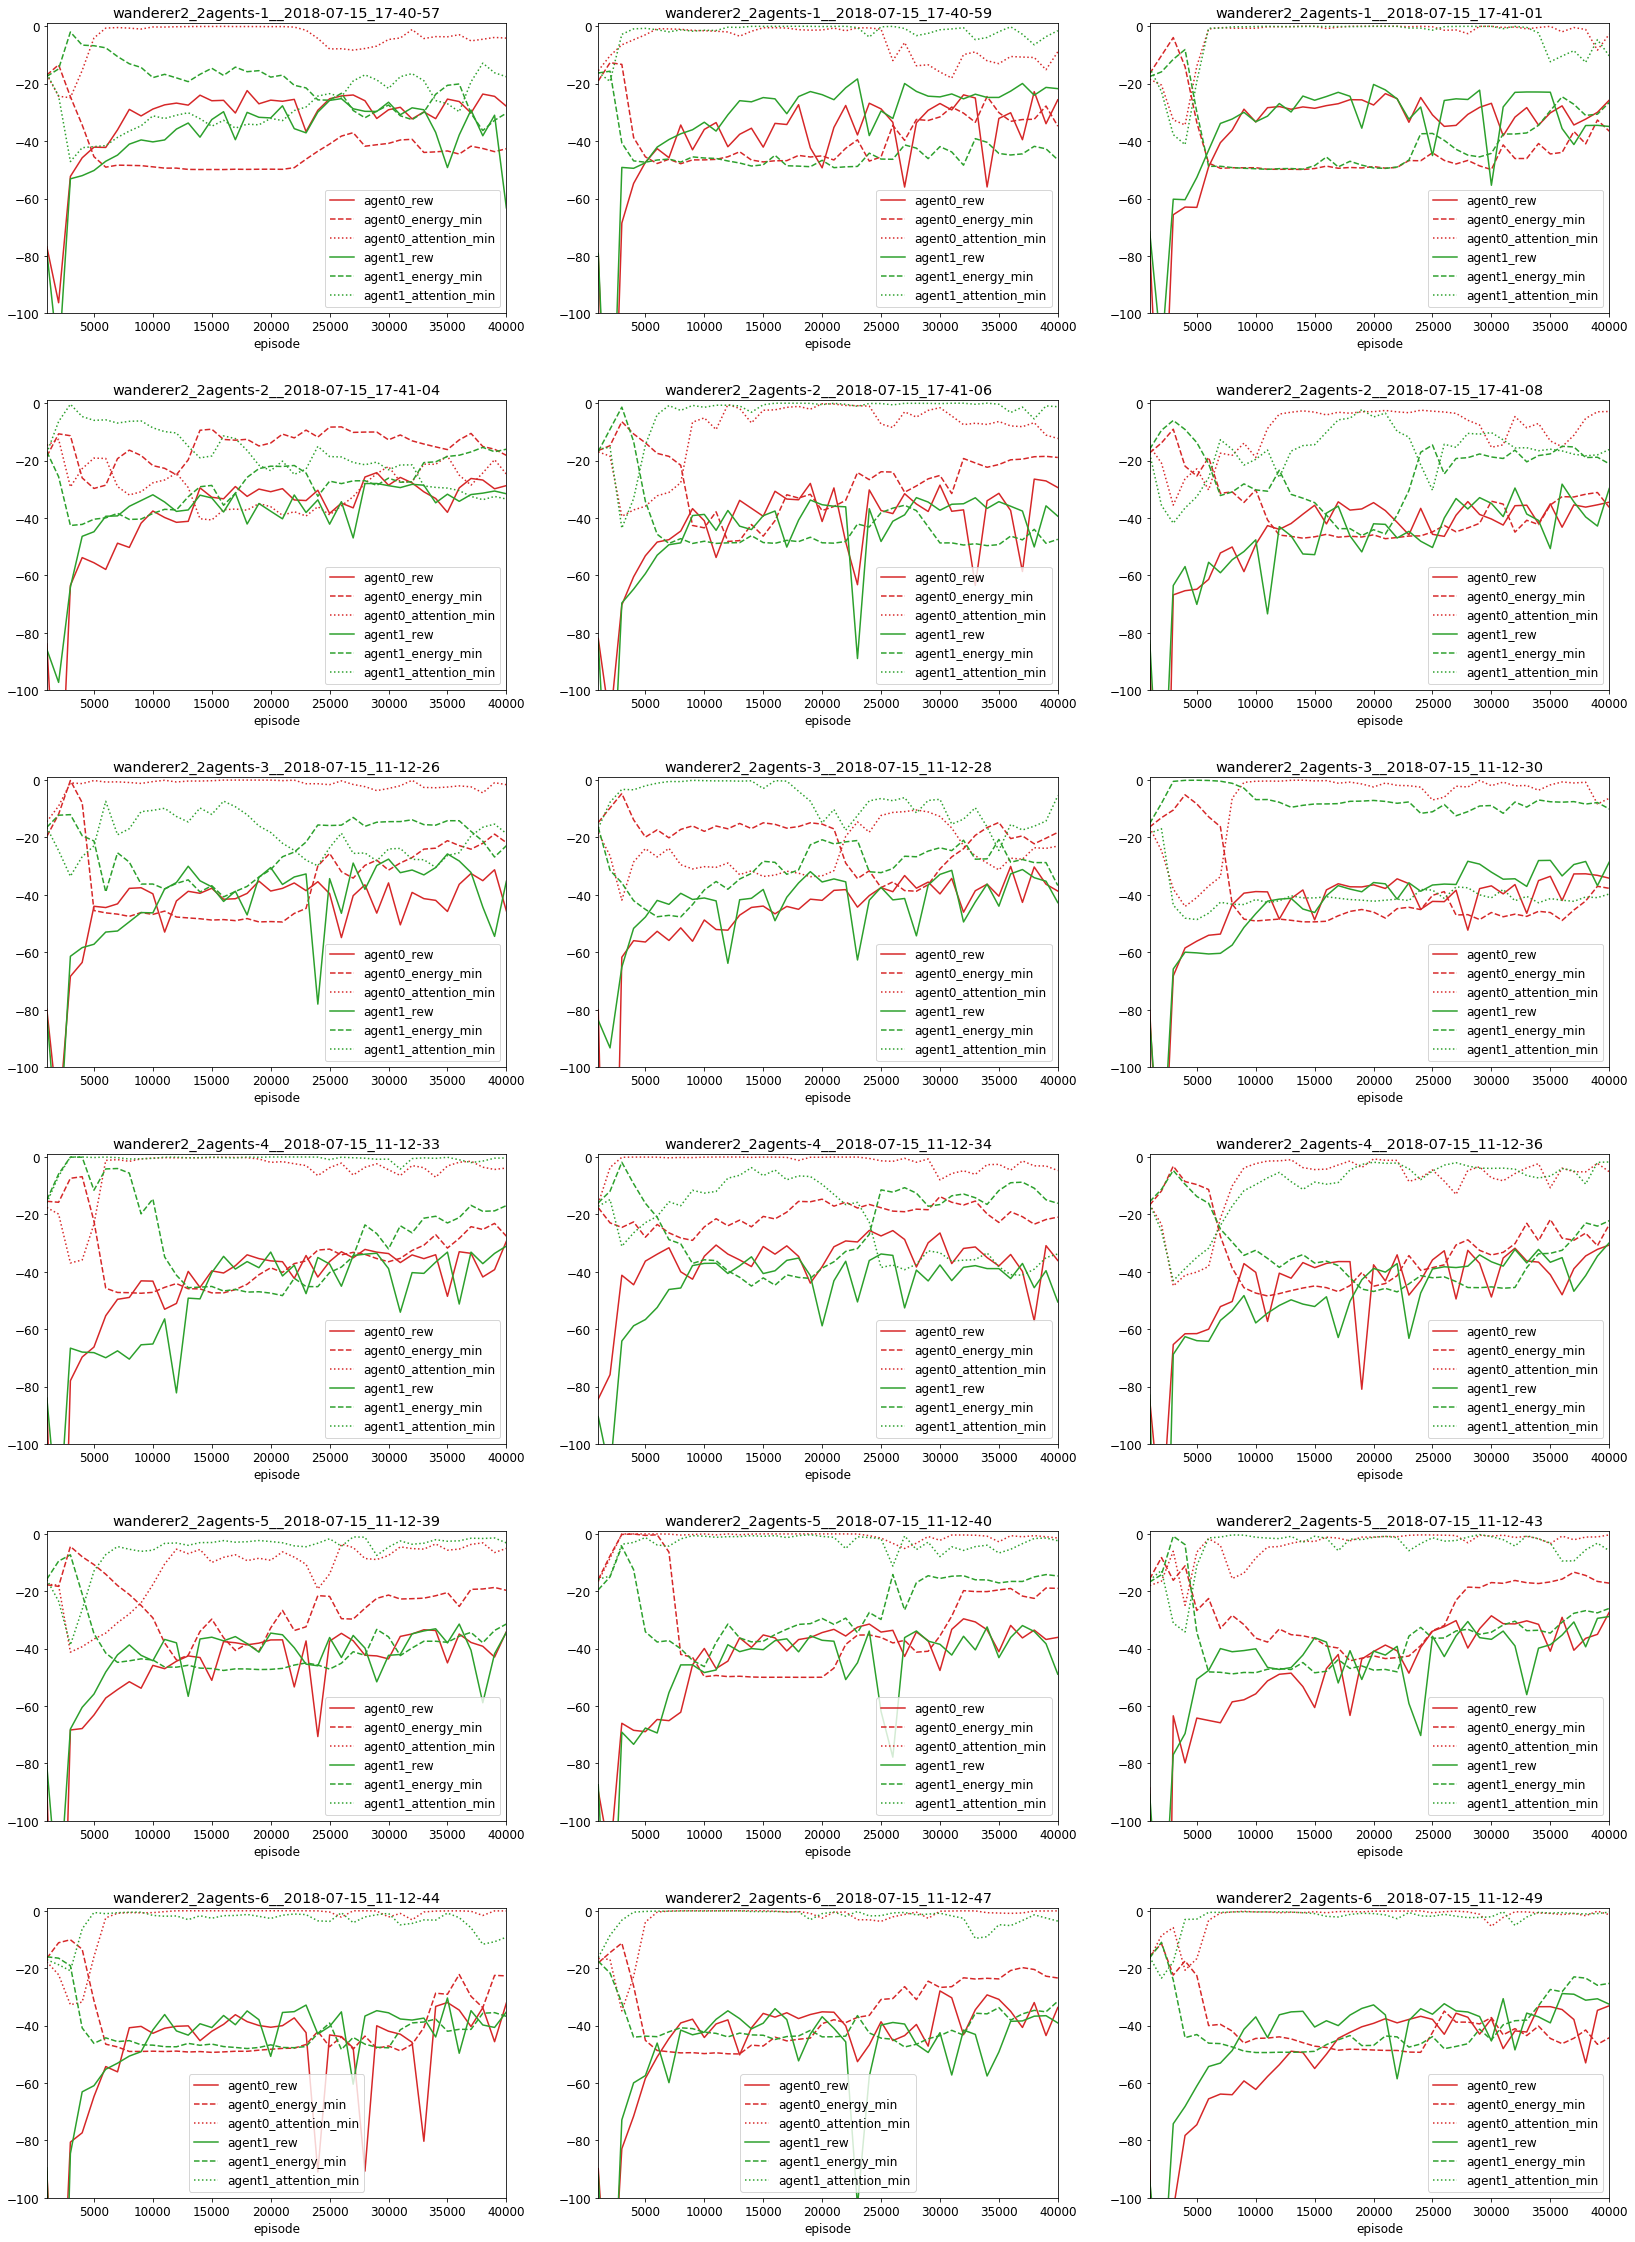

In [2]:
exp_dir = '../exp_results/exp10_180715'
# y_columns = ['energy_min', 'attention_min']
y_columns = ['rew', 'energy_min', 'attention_min']
fig, axes = plt.subplots(6, 3, figsize=(28, 40))
plt.subplots_adjust(hspace=0.3)
axes = axes.flatten()

curve_dirs = get_all_exp_curves(exp_dir)
for i, curve_dir in enumerate(curve_dirs):
    ax = axes[i]
    plot_curves(ax, curve_dir, y_columns)


In [3]:
y_columns = ['rew', 'energy_min', 'attention_min']

def show_results(exp_dir, each_exp_dir, epis):
    # training plot
    each_exp_dir = osp.join(exp_dir, each_exp_dir)
    plot_training(each_exp_dir, y_columns)
    plt.show()

    fn_video_template = 'video-{}.mp4'
    for epi in epis:
        print('-' * 50)
        print('Episode %d' % epi)
        print('-' * 50)
        fn_video = fn_video_template.format(epi)
        display(utils_note.play_linked_video(each_exp_dir, fn_video))
        video_path = osp.join(each_exp_dir, 'videos', fn_video)
        plot_energy(video_path)
        plt.show()
    print('~o**' * 20)

# 2. Agents' behvior of the trained model
Each experiment result contains  
1. learning cuve (training log)
2. video of the trained agents' behavior
3. the corresponding log of the energy consumption 

The learning curve is the same as that of Section1.  
In the video of #2, the agents represent large colorful circles and the goal is a black point.  
The tranparent circle around the agent represents the visible range,   
which increases as the agent uses its energy.   
Here the video contains 5 episodes.  

The figure of #3 shows the corresponding log of the energy and the attention consumption  
of #2 video. The line color corresponds to the agent color of #2 video.  
There are 50 stesp in each episode so that the energy is reset at 0 (default value)   
every 50 steps. 

## 2-1. wanderer2_2agents-1
 (penalty_weight=0.0, penalty_weight2=0.0)  
 
### results
In most cases, the agents use not "attention" but "energy".  
When "PENALTY_WEIGHT (for energy)" is zero, just using the energy  
to get a wider view range looks a better choice in this parameter set.

i.e., almost all agents become 'independent' (see 'summary' in the first cell).


oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
Experiment of "wanderer2_2agents-1__2018-07-15_17-40-57"
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo



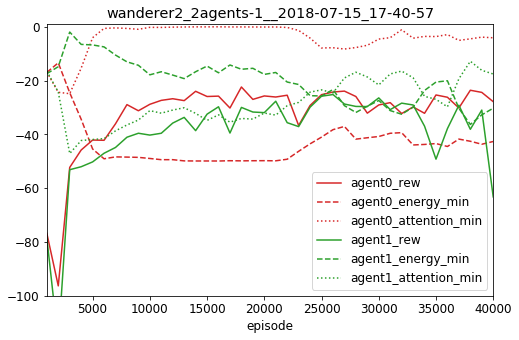

--------------------------------------------------
Episode 40000
--------------------------------------------------
./videos/wanderer2_2agents-1__2018-07-15_17-40-57/videos/video-40000.mp4


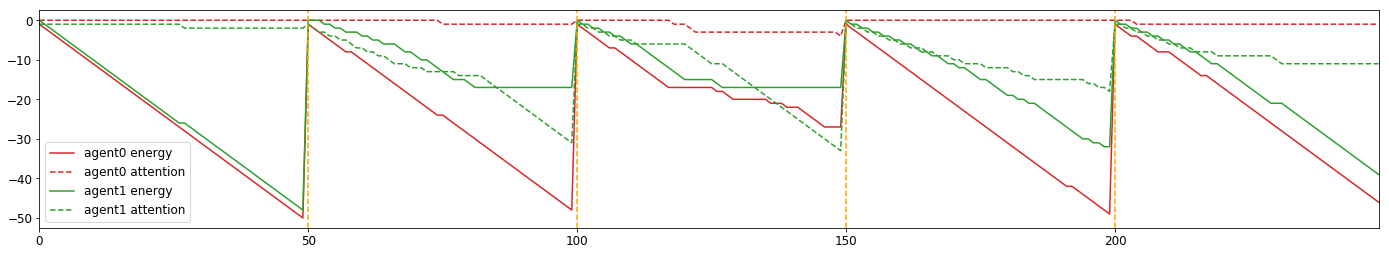

~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
Experiment of "wanderer2_2agents-1__2018-07-15_17-41-01"
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo



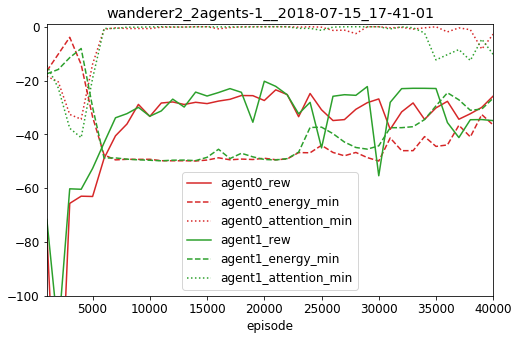

--------------------------------------------------
Episode 40000
--------------------------------------------------
./videos/wanderer2_2agents-1__2018-07-15_17-41-01/videos/video-40000.mp4


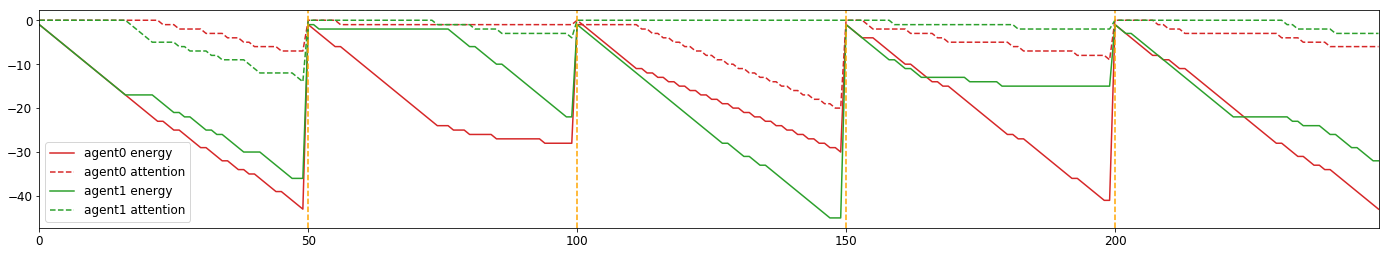

~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**


In [4]:
exp_dir = '../exp_results/exp10_180715/'
each_dirs = ['wanderer2_2agents-1__2018-07-15_17-40-57',
                       'wanderer2_2agents-1__2018-07-15_17-41-01']
epis = [40000]

for each_exp_dir in each_dirs:
    print('\n' + 'o'*60 + '\nExperiment of "%s"\n' %  each_exp_dir + 'o'*60 + '\n')
    show_results(exp_dir, each_exp_dir, epis)

## 2-2. wanderer2_2agents-2
 (penalty_weight=0.01, penalty_weight2=0.0)  
 
### results
The reuslts are different for different training seeds.  

#### 2018-07-15_17-41-04
The two agnets converge to the same behavior. First they alternately use  
the energy and the attention; they can find each other and get close.  
Because they consume the energy, each/both of the agents finally find   
the goal. After reaching the goal, they save the energy.

i.e., both agents are 'hybrid'.

#### 2018-07-15_17-41-06
Both agents tend to consume the energy (not the attention).  
The average of the obtained rewards is lower than that of "17-41-04",  
which suggests that the hybrid consumption is the optimized behavior  
for this game.

i.e., both agents are 'independent'.



oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
Experiment of "wanderer2_2agents-2__2018-07-15_17-41-04"
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo



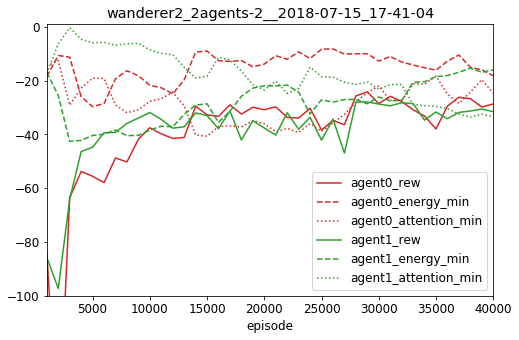

--------------------------------------------------
Episode 40000
--------------------------------------------------
./videos/wanderer2_2agents-2__2018-07-15_17-41-04/videos/video-40000.mp4


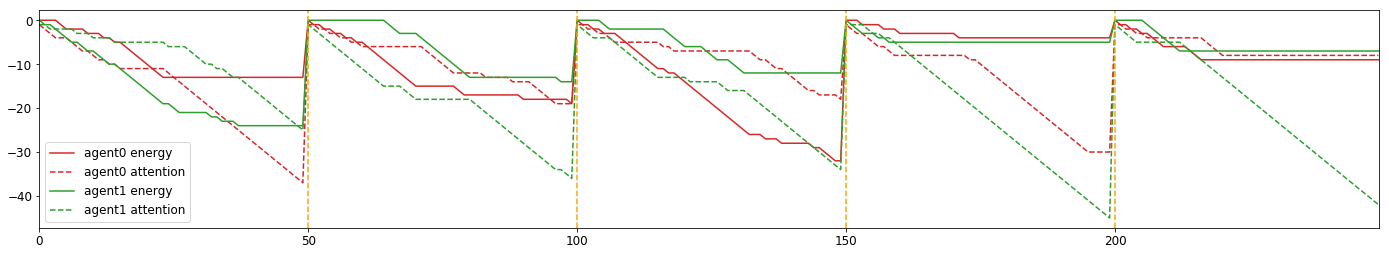

~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
Experiment of "wanderer2_2agents-2__2018-07-15_17-41-06"
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo



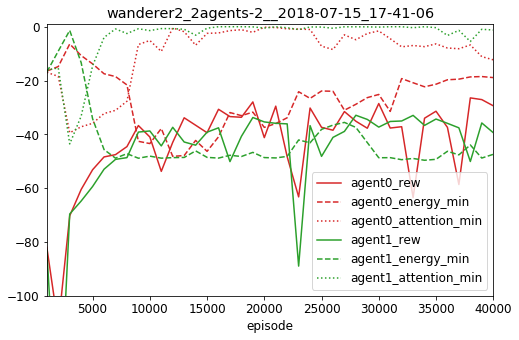

--------------------------------------------------
Episode 40000
--------------------------------------------------
./videos/wanderer2_2agents-2__2018-07-15_17-41-06/videos/video-40000.mp4


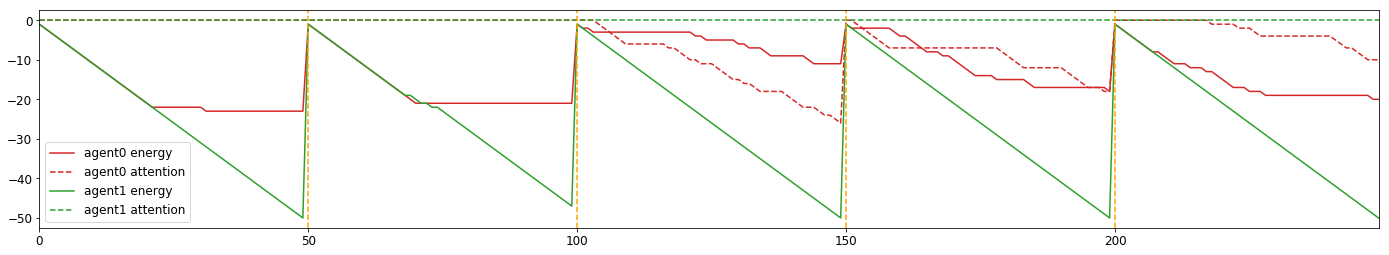

~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**


In [5]:
exp_dir = '../exp_results/exp10_180715/'
each_dirs = ['wanderer2_2agents-2__2018-07-15_17-41-04',
                       'wanderer2_2agents-2__2018-07-15_17-41-06']
epis = [40000]

for each_exp_dir in each_dirs:
    print('\n' + 'o'*60 + '\nExperiment of "%s"\n' %  each_exp_dir + 'o'*60 + '\n')
    show_results(exp_dir, each_exp_dir, epis)

## 2-3. wanderer2_2agents-3
 (penalty_weight=0.01, penalty_weight2=0.001)  
 
### results
#### 2018-07-15_11-12-26
The two agents' behavior looks similar; they don't use much attention.

independent & hybrid

#### 2018-07-15_11-12-30
This is very different from "2018-07-15_11-12-26". Agent1 is trained  
to be a follower: it doesn't use much energy and just follow Agent0 by  
using the attention. On the ohter hand, Agent0 almost only select using   
energy. In this case, the reward of Agent1 (follower) is better than that  
of Agent0.

independent & follower


oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
Experiment of "wanderer2_2agents-3__2018-07-15_11-12-26"
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo



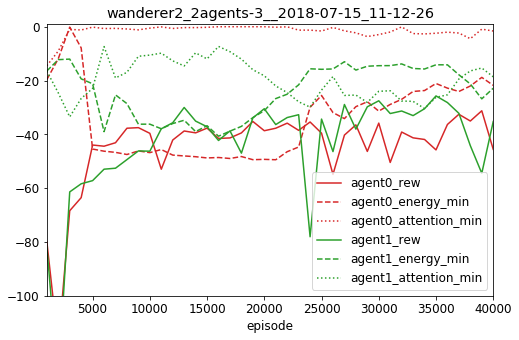

--------------------------------------------------
Episode 40000
--------------------------------------------------
./videos/wanderer2_2agents-3__2018-07-15_11-12-26/videos/video-40000.mp4


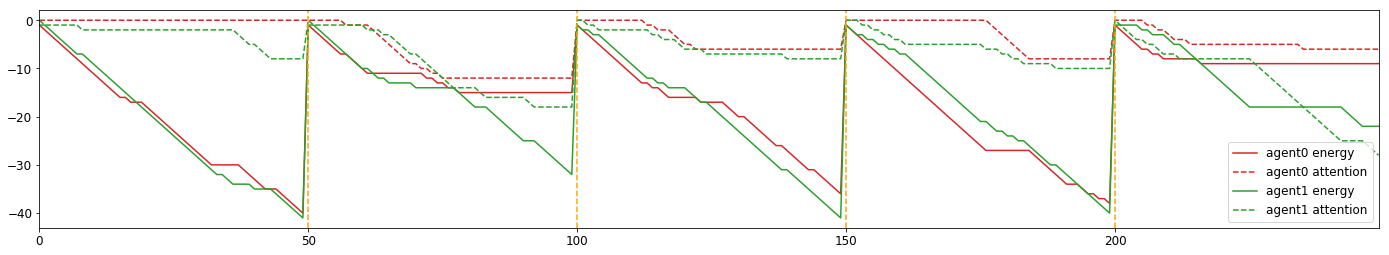

~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
Experiment of "wanderer2_2agents-3__2018-07-15_11-12-30"
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo



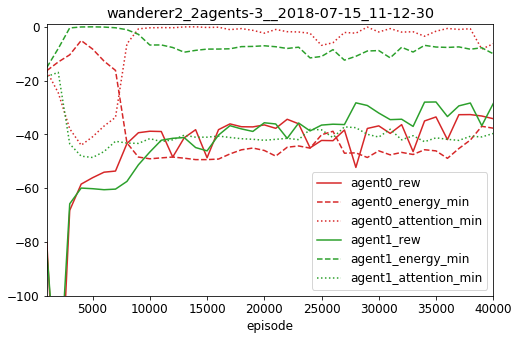

--------------------------------------------------
Episode 40000
--------------------------------------------------
./videos/wanderer2_2agents-3__2018-07-15_11-12-30/videos/video-40000.mp4


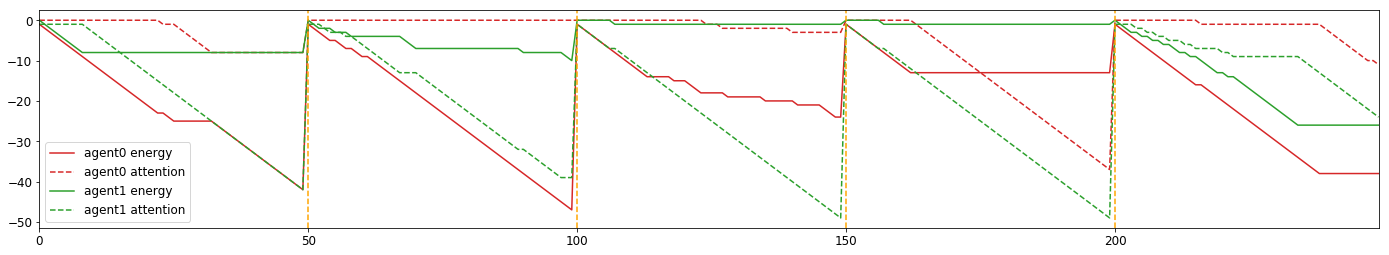

~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**


In [6]:
exp_dir = '../exp_results/exp10_180715/'
each_dirs = ['wanderer2_2agents-3__2018-07-15_11-12-26',
                       'wanderer2_2agents-3__2018-07-15_11-12-30']
epis = [40000]

for each_exp_dir in each_dirs:
    print('\n' + 'o'*60 + '\nExperiment of "%s"\n' %  each_exp_dir + 'o'*60 + '\n')
    show_results(exp_dir, each_exp_dir, epis)

## 2-4. wanderer2_2agents-4
 (penalty_weight=0.01, penalty_weight2=0.005)  
 
### results
The results are almost the same as "2agents-3":
- in one of the reuslts, the agnets' behavior converges to one.
- in the other case, one of the agents become the follower.

independent & hybrid


oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
Experiment of "wanderer2_2agents-4__2018-07-15_11-12-33"
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo



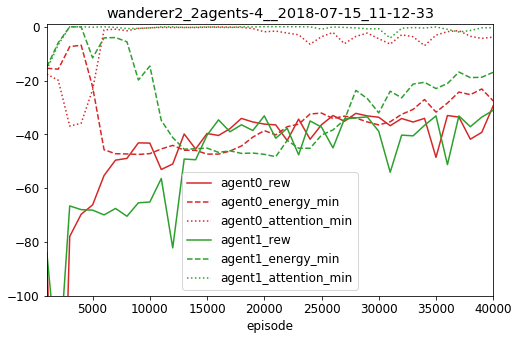

--------------------------------------------------
Episode 40000
--------------------------------------------------
./videos/wanderer2_2agents-4__2018-07-15_11-12-33/videos/video-40000.mp4


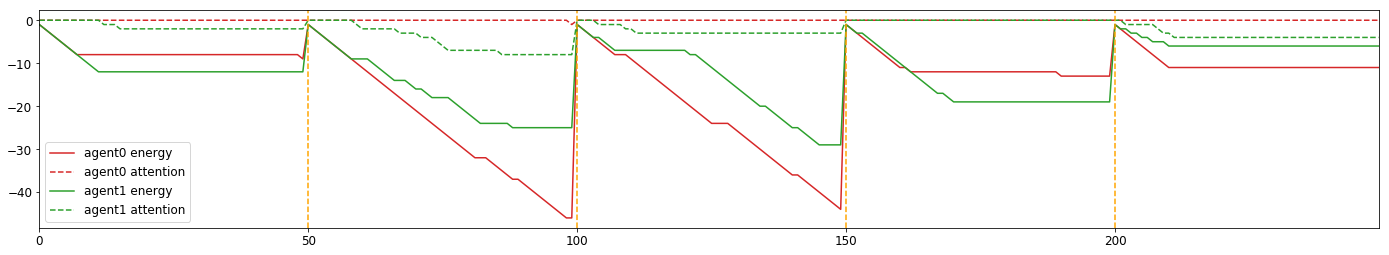

~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
Experiment of "wanderer2_2agents-4__2018-07-15_11-12-34"
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo



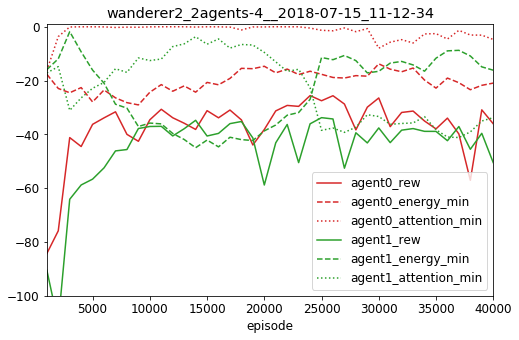

--------------------------------------------------
Episode 40000
--------------------------------------------------
./videos/wanderer2_2agents-4__2018-07-15_11-12-34/videos/video-40000.mp4


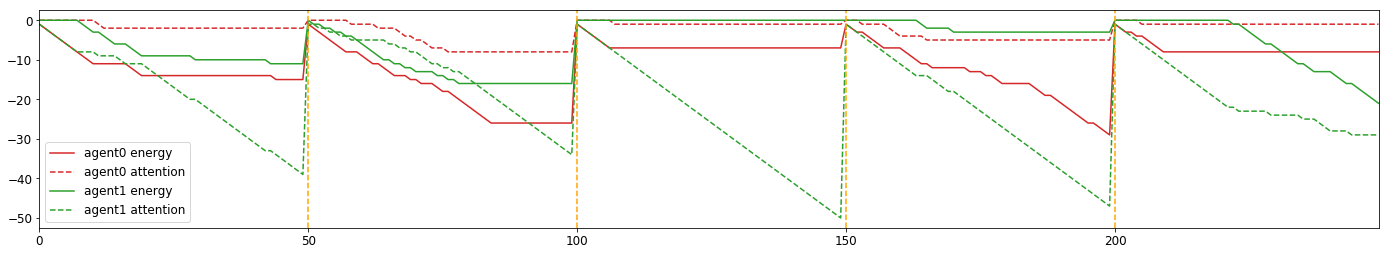

~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**


In [7]:
exp_dir = '../exp_results/exp10_180715/'
each_dirs = ['wanderer2_2agents-4__2018-07-15_11-12-33',
                       'wanderer2_2agents-4__2018-07-15_11-12-34']
epis = [40000]

for each_exp_dir in each_dirs:
    print('\n' + 'o'*60 + '\nExperiment of "%s"\n' %  each_exp_dir + 'o'*60 + '\n')
    show_results(exp_dir, each_exp_dir, epis)

## 2-5. wanderer2_2agents-5 & wanderer2_2agents-6
- wanderer2_2agents-5: penalty_weight=0.01, penalty_weight2=0.01
- wanderer2_2agents-6: penalty_weight=0.01, penalty_weight2=0.02

### results
PENALTY_WEGHT2 is too learge so that the agents only use "energy".  
"attention" is rarely used. The results are expected.

all: independent


oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
Experiment of "wanderer2_2agents-5__2018-07-15_11-12-43"
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo



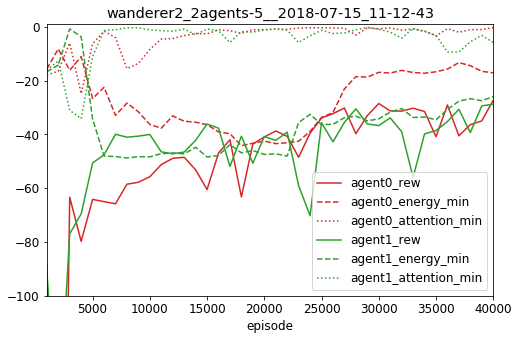

--------------------------------------------------
Episode 40000
--------------------------------------------------
./videos/wanderer2_2agents-5__2018-07-15_11-12-43/videos/video-40000.mp4


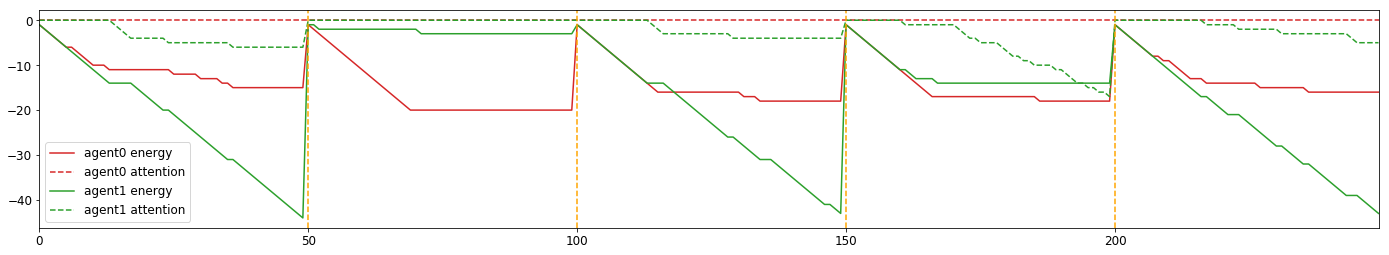

~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
Experiment of "wanderer2_2agents-6__2018-07-15_11-12-49"
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo



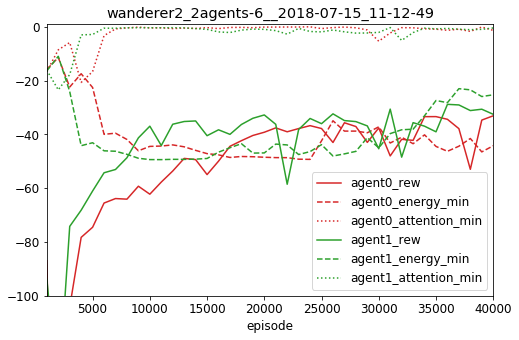

--------------------------------------------------
Episode 40000
--------------------------------------------------
./videos/wanderer2_2agents-6__2018-07-15_11-12-49/videos/video-40000.mp4


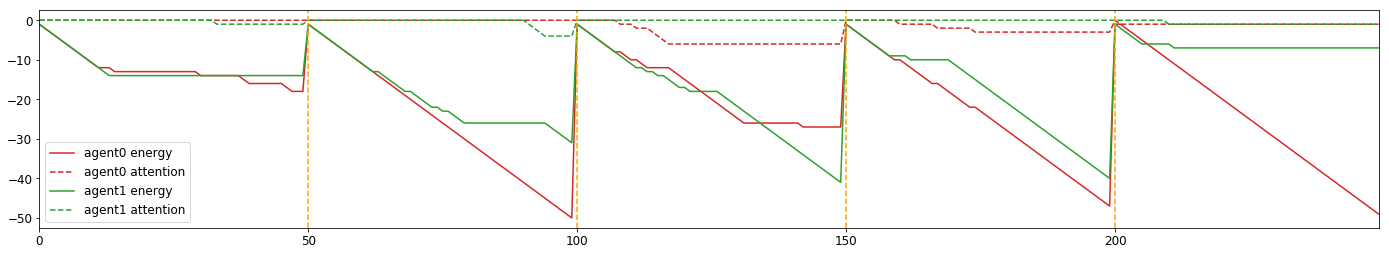

~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**~o**


In [8]:
exp_dir = '../exp_results/exp10_180715/'
each_dirs = ['wanderer2_2agents-5__2018-07-15_11-12-43',
                       'wanderer2_2agents-6__2018-07-15_11-12-49']
epis = [40000]

for each_exp_dir in each_dirs:
    print('\n' + 'o'*60 + '\nExperiment of "%s"\n' %  each_exp_dir + 'o'*60 + '\n')
    show_results(exp_dir, each_exp_dir, epis)